Dataset 'dataset_flora_fauna_indonesia.csv' sudah ada. Menggunakan dataset yang tersedia.
   ID     Nama_Flora   Nama_Fauna          Provinsi           Habitat  \
0   1  Bunga Bangkai       Komodo             Papua  Hutan Pegunungan   
1   2      Rafflesia   Elang Jawa       DKI Jakarta     Padang Rumput   
2   3     Mawar Jawa  Kucing Liar  Sulawesi Selatan          Mangrove   
3   4        Teratai       Komodo             Papua            Savana   
4   5         Melati   Elang Jawa  Sulawesi Selatan            Savana   

   Tahun_Observasi                                         Keterangan  
0             2023  Observasi persilangan antara Bunga Bangkai dan...  
1             2017  Observasi persilangan antara Rafflesia dan Ela...  
2             2019  Observasi persilangan antara Mawar Jawa dan Ku...  
3             2013  Observasi persilangan antara Teratai dan Komod...  
4             2014  Observasi persilangan antara Melati dan Elang ...  
<class 'pandas.core.frame.DataFrame'>
R

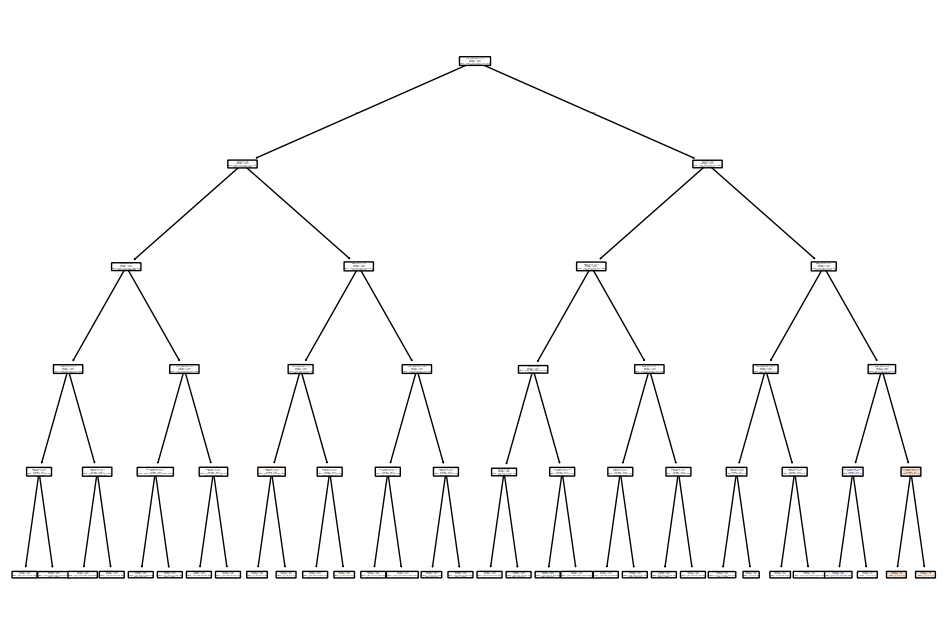

Feature Importances:
            Feature  Importance
3  Tahun_Observasi    0.329926
0       Nama_Flora    0.286076
1       Nama_Fauna    0.210766
2         Provinsi    0.173232
Aturan Keputusan:
IF Tahun_Observasi <= 17.50 AND Provinsi <= 6.50 AND Provinsi <= 3.50 AND Nama_Fauna <= 0.50 AND Nama_Flora <= 4.50 THEN Hutan Pegunungan (samples=695)
IF Tahun_Observasi <= 17.50 AND Provinsi <= 6.50 AND Provinsi <= 3.50 AND Nama_Fauna <= 0.50 AND Nama_Flora > 4.50 THEN Savana (samples=695)
IF Tahun_Observasi <= 17.50 AND Provinsi <= 6.50 AND Provinsi <= 3.50 AND Nama_Fauna > 0.50 AND Nama_Fauna <= 6.50 THEN Padang Rumput (samples=8502)
IF Tahun_Observasi <= 17.50 AND Provinsi <= 6.50 AND Provinsi <= 3.50 AND Nama_Fauna > 0.50 AND Nama_Fauna > 6.50 THEN Hutan Pegunungan (samples=4318)
IF Tahun_Observasi <= 17.50 AND Provinsi <= 6.50 AND Provinsi > 3.50 AND Tahun_Observasi <= 8.50 AND Tahun_Observasi <= 4.50 THEN Mangrove (samples=2999)
IF Tahun_Observasi <= 17.50 AND Provinsi <= 6.50 AND Provi

In [6]:
import os
import csv
import random
import datetime
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import matplotlib.pyplot as plt

# ===================== Parameterisasi =====================
# Dataset Sintetik
jumlah_baris = 50000  # Ubah jumlah baris sesuai kebutuhan (max 75000)
nama_file = 'dataset_flora_fauna_indonesia.csv'

# Fitur dan Target untuk Decision Tree
feature_cols = ['Nama_Flora', 'Nama_Fauna', 'Provinsi', 'Tahun_Observasi']
target_col = 'Habitat'  # Target klasifikasi (MULTICLASS)
classification_type = 'MULTICLASS'
max_depth = 5  # atur untuk mencegah overfitting

# ===================== 1. Generate Dataset Sintetik =====================
# Cek apakah file sudah ada
if not os.path.exists(nama_file):
    flora_list = [
        "Rafflesia", "Anggrek Hitam", "Melati", "Kamboja", "Mawar Jawa",
        "Bunga Bangkai", "Kemuning", "Kapas", "Cempaka", "Teratai"
    ]
    fauna_list = [
        "Harimau Sumatera", "Orangutan", "Komodo", "Elang Jawa", "Badak Jawa",
        "Gajah Sumatera", "Macan Tutul", "Bekantan", "Kucing Liar", "Kijang"
    ]
    provinsi_list = [
        "Aceh", "Bali", "Banten", "DKI Jakarta", "Jawa Barat",
        "Jawa Tengah", "Jawa Timur", "Kalimantan Selatan", "Sulawesi Selatan", "Papua"
    ]
    habitat_list = [
        "Hutan Tropis", "Savana", "Mangrove", "Padang Rumput", "Hutan Pegunungan"
    ]

    def random_date():
        start = datetime.date(2000, 1, 1)
        end = datetime.date.today()
        delta = (end - start).days
        return start + datetime.timedelta(days=random.randint(0, delta))

    with open(nama_file, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'ID', 'Nama_Flora', 'Nama_Fauna', 'Provinsi', 'Habitat', 'Tahun_Observasi', 'Keterangan'
        ])
        writer.writeheader()
        for i in range(1, jumlah_baris + 1):
            flora = random.choice(flora_list)
            fauna = random.choice(fauna_list)
            prov = random.choice(provinsi_list)
            hab = random.choice(habitat_list)
            year = random_date().year
            keterangan = f"Observasi persilangan antara {flora} dan {fauna} di {prov} pada habitat {hab}."
            writer.writerow({
                'ID': i,
                'Nama_Flora': flora,
                'Nama_Fauna': fauna,
                'Provinsi': prov,
                'Habitat': hab,
                'Tahun_Observasi': year,
                'Keterangan': keterangan
            })
    print(f"Dataset sintetik berhasil dibuat: '{nama_file}' ({jumlah_baris} baris)")
else:
    print(f"Dataset '{nama_file}' sudah ada. Menggunakan dataset yang tersedia.")

# ===================== 2. Pembacaan & Eksplorasi Data =====================
df = pd.read_csv(nama_file)
print(df.head())
print(df.info())
print(df.describe(include='all'))
print(f"Distribusi '{target_col}':\n", df[target_col].value_counts())

# ===================== 3. Perhitungan Entropi & Information Gain =====================

def calculate_entropy(series):
    counts = series.value_counts()
    total = len(series)
    entropy = -sum((c/total) * math.log2(c/total) for c in counts if c>0)
    return entropy


def calculate_initial_entropy(df, target):
    return calculate_entropy(df[target])


def calculate_information_gain(df, feature, target):
    parent_ent = calculate_initial_entropy(df, target)
    vals, counts = np.unique(df[feature], return_counts=True)
    weighted_ent = sum((cnt/len(df)) * calculate_entropy(df[df[feature]==v][target])
                       for v, cnt in zip(vals, counts))
    return parent_ent - weighted_ent

entropy_dict = {col: calculate_entropy(df[col]) for col in feature_cols}
ig_dict = {col: calculate_information_gain(df, col, target_col) for col in feature_cols}
ig_table = pd.DataFrame({
    'Feature': list(entropy_dict.keys()),
    'Entropy': list(entropy_dict.values()),
    'Information_Gain': list(ig_dict.values())
}).sort_values(by='Information_Gain', ascending=False)
print("Entropi & IG per fitur:\n", ig_table)

# ===================== 4. Preprocessing =====================
# Imputasi missing values dengan modus
df[feature_cols + [target_col]] = SimpleImputer(strategy='most_frequent').fit_transform(df[feature_cols + [target_col]])
# Label encoding
encoders = {}
for col in feature_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
le_tgt = LabelEncoder()
df[target_col] = le_tgt.fit_transform(df[target_col])
X = df[feature_cols]
y = df[target_col]

# ===================== 5. Model Decision Tree =====================
clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
clf.fit(X, y)
print(f"Akurasi training: {clf.score(X, y):.4f}")

# ===================== 6. Visualisasi & Interpretasi =====================
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=feature_cols, class_names=le_tgt.classes_, filled=True, rounded=True)
plt.show()

fi = pd.DataFrame({'Feature': feature_cols, 'Importance': clf.feature_importances_})
print("Feature Importances:\n", fi.sort_values('Importance', ascending=False))

# ===================== 7. Ekstraksi Aturan Keputusan =====================
from sklearn.tree import _tree

def extract_rules(tree_model, features, targets):
    tree_ = tree_model.tree_
    feat = [features[i] if i != _tree.TREE_UNDEFINED else 'leaf' for i in tree_.feature]
    rules = []
    def recurse(node, conds):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feat[node]
            thr = tree_.threshold[node]
            recurse(tree_.children_left[node], conds + [f"{name} <= {thr:.2f}"])
            recurse(tree_.children_right[node], conds + [f"{name} > {thr:.2f}"])
        else:
            vals = tree_.value[node][0]
            cls = targets[np.argmax(vals)]
            samples = int(tree_.n_node_samples[node])
            rules.append(f"IF {' AND '.join(conds)} THEN {cls} (samples={samples})")
    recurse(0, [])
    return rules

rules = extract_rules(clf, feature_cols, le_tgt.classes_)
print("Aturan Keputusan:")
for r in rules: print(r)

# ===================== 8. Randomizer Data & Prediksi =====================
def random_data_selector(data, n_samples=5):
    """
    Randomly selects n_samples from the dataset and displays them clearly
    
    Args:
        data: Pandas DataFrame
        n_samples: Number of samples to select
    
    Returns:
        DataFrame with selected samples
    """
    selected_indices = random.sample(range(len(data)), n_samples)
    selected_data = data.iloc[selected_indices].copy()
    
    # Convert encoded values back to original labels
    for col, le in encoders.items():
        selected_data[col + '_Original'] = le.inverse_transform(selected_data[col])
    
    # Add habitat in original form
    selected_data['Habitat_Original'] = le_tgt.inverse_transform(selected_data['Habitat'])
    
    return selected_data

# Select random samples
n_samples = 5
random_samples = random_data_selector(df, n_samples)

# Display the selected data clearly
print(f"\n{'='*20} RANDOMLY SELECTED DATA {'='*20}")
for i in range(len(random_samples)):
    sample = random_samples.iloc[i]
    print(f"\nSample {i+1}:")
    print(f"Flora: {sample['Nama_Flora_Original']}")
    print(f"Fauna: {sample['Nama_Fauna_Original']}")
    print(f"Provinsi: {sample['Provinsi_Original']}")
    print(f"Tahun Observasi: {sample['Tahun_Observasi_Original']}")
    print(f"Habitat: {sample['Habitat_Original']}")
    print(f"ID: {sample['ID']}")
    print(f"Keterangan: {sample['Keterangan']}")
    print('-' * 50)

# Prediksi dengan menggunakan sampel yang terpilih secara acak
print(f"\n{'='*20} PREDIKSI PADA DATA TERPILIH {'='*20}")
for i in range(len(random_samples)):
    sample = random_samples.iloc[i]
    
    # Membuat data untuk prediksi (seolah-olah kita tidak tahu habitatnya)
    contoh_prediksi = pd.DataFrame([{
        'Nama_Flora': sample['Nama_Flora'],
        'Nama_Fauna': sample['Nama_Fauna'],
        'Provinsi': sample['Provinsi'],
        'Tahun_Observasi': sample['Tahun_Observasi']
    }])
    
    # Lakukan prediksi
    prediksi = clf.predict(contoh_prediksi)
    habitat_prediksi = le_tgt.inverse_transform(prediksi)[0]
    
    # Bandingkan hasil prediksi dengan data sebenarnya
    print(f"\nPrediksi untuk Sample {i+1}:")
    print(f"Flora: {sample['Nama_Flora_Original']}")
    print(f"Fauna: {sample['Nama_Fauna_Original']}")
    print(f"Provinsi: {sample['Provinsi_Original']}")
    print(f"Tahun Observasi: {sample['Tahun_Observasi_Original']}")
    print(f"Habitat Sebenarnya: {sample['Habitat_Original']}")
    print(f"Habitat Prediksi: {habitat_prediksi}")
    
    # Cek apakah prediksi benar
    if sample['Habitat_Original'] == habitat_prediksi:
        print("✓ Prediksi BENAR")
    else:
        print("✗ Prediksi SALAH")
    print('-' * 50)